## Course Assignment Instructions
You should have Python (version 3.8 or later) and Jupyter Notebook installed to complete this assignment. You will write code in the empty cell/cells below the problem. While most of this will be a programming assignment, some questions will ask you to "write a few sentences" in markdown cells. 

Submission Instructions:

Create a labs directory in your personal class repository (e.g., located in your home directory)
Clone the class repository
Copy this Jupyter notebook file (.ipynb) into your repo/labs directory
Make your edits, commit changes, and push to your repository
All submissions must be pushed before the due date to avoid late penalties. 

Labs are graded out of a 100 pts. Each day late is -10. For a max penalty of -50 after 5 days. From there you may submit the lab anytime before the semester ends for a max score of 50.  

Lab 9 is due on 

## Data Munging: a realistic exercise

We will be constructing a data frame which will then get passed on to the model-building. We will be joining three datasets in an effort to make a design matrix that predicts if a bill will be paid on time. Clean up and load up the three files. Then I'll rename a few features and then we can examine the data frames.

In [1]:
import pandas as pd

# Read compressed CSV files (bz2 compression is handled automatically)
bills = pd.read_csv("bills.csv.bz2", compression = "bz2")
payments = pd.read_csv("payments.csv.bz2", compression = "bz2")
discounts = pd.read_csv("discounts.csv.bz2", compression = "bz2")

print(bills.info())
print(payments.info())
print(discounts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226434 entries, 0 to 226433
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            226434 non-null  float64
 1   due_date      226434 non-null  object 
 2   invoice_date  226434 non-null  object 
 3   amount        226434 non-null  float64
 4   customer_id   226434 non-null  int64  
 5   discount_id   225121 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 10.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194850 entries, 0 to 194849
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                194850 non-null  float64
 1   amount            194850 non-null  float64
 2   transaction_date  194850 non-null  object 
 3   bill_id           194850 non-null  float64
dtypes: float64(3), object(1)
memory usage: 5.9+ MB
None
<class 'pandas.

In [2]:
# Rename columns 
bills.rename(columns = {"amount": "tot_amount"}, inplace = True)
payments.rename(columns = {"amount": "paid_amount"}, inplace = True)

# Get a quick summary of the data
print("Bills dataset info:")
print(bills.info())
print("\nBills dataset summary:")
print(bills.describe(include='all'))

print("\nPayments dataset info:")
print(payments.info())
print("\nPayments dataset summary:")
print(payments.describe(include='all'))

print("\nDiscounts dataset info:")
print(discounts.info())
print("\nDiscounts dataset summary:")
print(discounts.describe(include='all'))

Bills dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226434 entries, 0 to 226433
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            226434 non-null  float64
 1   due_date      226434 non-null  object 
 2   invoice_date  226434 non-null  object 
 3   tot_amount    226434 non-null  float64
 4   customer_id   226434 non-null  int64  
 5   discount_id   225121 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 10.4+ MB
None

Bills dataset summary:
                  id    due_date invoice_date    tot_amount   customer_id  \
count   2.264340e+05      226434       226434  2.264340e+05  2.264340e+05   
unique           NaN        1820         1728           NaN           NaN   
top              NaN  2017-06-30   2016-12-19           NaN           NaN   
freq             NaN        1265         2018           NaN           NaN   
mean    1.640070e+07         NaN         

Uncomment the next three cells if you want to generate advanced profiling report using ydata_profiling

In [ ]:
#import ydata_profiling 

#Generate an advanced report using `ydata_profiling`
#bills_profile = ydata_profiling.ProfileReport(bills, title="Bills Dataset Summary", explorative=True)
#payments_profile = ydata_profiling.ProfileReport(payments, title="Payments Dataset Summary", explorative=True)
#discounts_profile = ydata_profiling.ProfileReport(discounts, title="Discounts Dataset Summary", explorative=True)

#bills_profile.to_notebook_iframe()

In [ ]:
#payments_profile.to_notebook_iframe()

In [ ]:
#discounts_profile.to_notebook_iframe()

The unit we care about is the bill. The y metric we care about will be "paid in full" which is 1 if the company paid their total amount (we will generate this y metric later).

Since this is the response, we would like to construct the very best design matrix in order to predict y.

First, join the three datasets in an intelligent way. You will need to examine the datasets beforehand.

In [6]:
bills.to_csv("bills.csv", index=False)
payments.to_csv("payments.csv", index=False)
discounts.to_csv("discounts.csv", index=False)

In [7]:
#Group by 'bill_id' and sum the 'paid_amount'
total_payments = payments.groupby("bill_id", as_index = False)["paid_amount"].sum()

#Rename the column to 'total_paid_amount'
total_payments.rename(columns = {"paid_amount" : "total_paid_amount"}, inplace = True)

#Display the first few rows of the new dataframe
total_payments

,bill_id,total_paid_amount
0,5000000.0,99150.433262
1,5693147.0,99220.416116
2,6098612.0,99148.072512
3,6386294.0,99154.665161
4,6609438.0,99148.072512
...,...,...
142161,17618788.0,198296.997459
142162,17618791.0,198799.511682
142163,17618795.0,99184.100012
142164,17618798.0,99165.589946


In [8]:
#Subset the payments dataset to only the needed columns
payments_subset = total_payments[["bill_id", "total_paid_amount"]]

#Merge bills with the subset of total_payments on bills.id = payments.bill_id using a left join
merged_df = pd.merge(bills, payments_subset, left_on = "id", right_on = "bill_id", how = "left")

#Display the first few rows of the merged dataframe
print(merged_df.head())

           id    due_date invoice_date    tot_amount  customer_id  \
0  15163811.0  2017-02-12   2017-01-13  99490.770818     14290629   
1  17244832.0  2016-03-22   2016-02-21  99475.734482     14663516   
2  16072776.0  2016-08-31   2016-07-17  99477.028034     14569622   
3  15446684.0  2017-05-29   2017-05-29  99478.602777     14488427   
4  16257142.0  2017-06-09   2017-05-10  99678.169700     14497172   

   discount_id     bill_id  total_paid_amount  
0    5693147.0  15163811.0       99175.702456  
1    5693147.0  17244832.0       99149.345436  
2    7302585.0         NaN                NaN  
3    5693147.0  15446684.0       99154.373237  
4    5693147.0  16257142.0       99504.191787  


In [12]:
#Subset the discounts dataset to include only the id and pct_off columns
discounts_subset = discounts[["id", "pct_off"]]

#Merge the pct_off column into the bills dataset by matching bills.dicount_id with discounts.id
bills_data = pd.merge(merged_df, discounts_subset, left_on = "discount_id", right_on = "id", how = "left")

bills_data

,id_x,due_date,invoice_date,tot_amount,customer_id,discount_id,bill_id,total_paid_amount,id_y,pct_off
0,15163811.0,2017-02-12,2017-01-13,99490.770818,14290629,5693147.0,15163811.0,99175.702456,5693147.0,2.0
1,17244832.0,2016-03-22,2016-02-21,99475.734482,14663516,5693147.0,17244832.0,99149.345436,5693147.0,2.0
2,16072776.0,2016-08-31,2016-07-17,99477.028034,14569622,7302585.0,NaN,NaN,7302585.0,NaN
3,15446684.0,2017-05-29,2017-05-29,99478.602777,14488427,5693147.0,15446684.0,99154.373237,5693147.0,2.0
4,16257142.0,2017-06-09,2017-05-10,99678.169700,14497172,5693147.0,16257142.0,99504.191787,5693147.0,2.0
...,...,...,...,...,...,...,...,...,...,...
226429,17602383.0,2015-10-10,2015-08-26,99479.693994,13685247,8218876.0,NaN,NaN,8218876.0,NaN
226430,17602386.0,2017-07-12,2017-07-12,99499.995838,12869402,8218876.0,NaN,NaN,8218876.0,NaN
226431,14911456.0,2015-09-17,2015-08-18,99497.421222,13146999,8218876.0,14911456.0,99186.966987,8218876.0,NaN
226432,17250993.0,2017-06-21,2017-05-07,99486.388780,12866339,7397895.0,NaN,NaN,7397895.0,NaN


In [14]:
bills_data["discount_amount"] = bills_data["tot_amount"] * bills_data["pct_off"] / 100

#Fill missing values with 0 (if a bill has no associated payment or discount)
bills_data['total_paid_amount'] = bills_data["total_paid_amount"].fillna(0)
bills_data['discount_amount'] = bills_data["discount_amount"].fillna(0)

#Compute effective bill total by applying discount to the total amount
bills_data['effective_total'] = bills_data["tot_amount"] - bills_data["discount_amount"]
bills_data

,id_x,due_date,invoice_date,tot_amount,customer_id,discount_id,bill_id,total_paid_amount,id_y,pct_off,discount_amount,effective_total
0,15163811.0,2017-02-12,2017-01-13,99490.770818,14290629,5693147.0,15163811.0,99175.702456,5693147.0,2.0,1989.815416,97500.955402
1,17244832.0,2016-03-22,2016-02-21,99475.734482,14663516,5693147.0,17244832.0,99149.345436,5693147.0,2.0,1989.514690,97486.219793
2,16072776.0,2016-08-31,2016-07-17,99477.028034,14569622,7302585.0,NaN,0.000000,7302585.0,NaN,0.000000,99477.028034
3,15446684.0,2017-05-29,2017-05-29,99478.602777,14488427,5693147.0,15446684.0,99154.373237,5693147.0,2.0,1989.572056,97489.030722
4,16257142.0,2017-06-09,2017-05-10,99678.169700,14497172,5693147.0,16257142.0,99504.191787,5693147.0,2.0,1993.563394,97684.606306
...,...,...,...,...,...,...,...,...,...,...,...,...
226429,17602383.0,2015-10-10,2015-08-26,99479.693994,13685247,8218876.0,NaN,0.000000,8218876.0,NaN,0.000000,99479.693994
226430,17602386.0,2017-07-12,2017-07-12,99499.995838,12869402,8218876.0,NaN,0.000000,8218876.0,NaN,0.000000,99499.995838
226431,14911456.0,2015-09-17,2015-08-18,99497.421222,13146999,8218876.0,14911456.0,99186.966987,8218876.0,NaN,0.000000,99497.421222
226432,17250993.0,2017-06-21,2017-05-07,99486.388780,12866339,7397895.0,NaN,0.000000,7397895.0,NaN,0.000000,99486.388780


Now create the binary response metric `paid_in_full` as the last column and create the beginnings of a design matrix `bills_data`. Ensure the unit / observation is bill i.e. each row should be ONE bill ONLY! 

In [17]:
# Create the target variable "paid_in_full": It is 1 if the total paid is at least the effective total; otherwise, it is 0.
bills_data['paid_in_full'] = (bills_data["total_paid_amount"] >= bills_data["effective_total"]).astype(int)

bills_data

,id_x,due_date,invoice_date,tot_amount,customer_id,discount_id,bill_id,total_paid_amount,id_y,pct_off,discount_amount,effective_total,paid_in_full
0,15163811.0,2017-02-12,2017-01-13,99490.770818,14290629,5693147.0,15163811.0,99175.702456,5693147.0,2.0,1989.815416,97500.955402,1
1,17244832.0,2016-03-22,2016-02-21,99475.734482,14663516,5693147.0,17244832.0,99149.345436,5693147.0,2.0,1989.514690,97486.219793,1
2,16072776.0,2016-08-31,2016-07-17,99477.028034,14569622,7302585.0,NaN,0.000000,7302585.0,NaN,0.000000,99477.028034,0
3,15446684.0,2017-05-29,2017-05-29,99478.602777,14488427,5693147.0,15446684.0,99154.373237,5693147.0,2.0,1989.572056,97489.030722,1
4,16257142.0,2017-06-09,2017-05-10,99678.169700,14497172,5693147.0,16257142.0,99504.191787,5693147.0,2.0,1993.563394,97684.606306,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226429,17602383.0,2015-10-10,2015-08-26,99479.693994,13685247,8218876.0,NaN,0.000000,8218876.0,NaN,0.000000,99479.693994,0
226430,17602386.0,2017-07-12,2017-07-12,99499.995838,12869402,8218876.0,NaN,0.000000,8218876.0,NaN,0.000000,99499.995838,0
226431,14911456.0,2015-09-17,2015-08-18,99497.421222,13146999,8218876.0,14911456.0,99186.966987,8218876.0,NaN,0.000000,99497.421222,0
226432,17250993.0,2017-06-21,2017-05-07,99486.388780,12866339,7397895.0,NaN,0.000000,7397895.0,NaN,0.000000,99486.388780,0


In [36]:
# List of columns we intended to drop
cols_to_drop = ['id_x', 'id_y', 'bill_id', 'discount_id', 'invoice_date', 'due_date']

# Drop only those that exist in the current DataFrame
bills_data.drop(columns=[col for col in cols_to_drop if col in bills_data.columns], inplace=True)

# Export to CSV
bills_data.to_csv("bills_data.csv", index=False)


How should you add features from transformations (called "featurization")? What data type(s) should they be? Make some features below if you think of any useful ones. Name the columns appropriately so another data scientist can easily understand what information is in your variables. Make sure missingness (if in a categorical variable) is treated as a legal level of that variable. Make sure the response variable is there too in the final data frame.

In [38]:
if "invoice_date" in bills_data.columns and "due_date" in bills_data.columns:
    
    # Convert to datetime
    bills_data["invoice_date"] = pd.to_datetime(bills_data["invoice_date"])
    bills_data["due_date"] = pd.to_datetime(bills_data["due_date"])
    
    # Feature 1: Days between invoice and due date
    bills_data["days_to_pay"] = (bills_data["due_date"] - bills_data["invoice_date"]).dt.days
    
    # Feature 2: Month and year of invoice (categorical)
    bills_data["invoice_month"] = bills_data["invoice_date"].dt.month.astype("category")
    bills_data["invoice_year"] = bills_data["invoice_date"].dt.year.astype("category")

# Feature 3: Has discount
bills_data["has_discount"] = bills_data["pct_off"].notna().astype("category")

# Feature 4: Payment ratio
bills_data["pay_ratio"] = (bills_data["total_paid_amount"] / bills_data["effective_total"]).clip(upper=2)

# Feature 5: Customer-level stats
customer_stats = bills_data.groupby("customer_id").agg(
    avg_bill_amount=("tot_amount", "mean"),
    num_bills=("tot_amount", "count")  # safer than id_x now
).reset_index()

bills_data = pd.merge(bills_data, customer_stats, on="customer_id", how="left")

# Feature 6: Handle missing pct_off
bills_data["pct_off"] = bills_data["pct_off"].fillna(-1)

# Final cleanup: only drop columns if they exist
cols_to_drop = ['id_x', 'id_y', 'bill_id', 'discount_id', 'invoice_date', 'due_date']
bills_data.drop(columns=[col for col in cols_to_drop if col in bills_data.columns], inplace=True)

# Export
bills_data.to_csv("design_matrix.csv", index=False)


# Regression Trees

We will use sklearn's `randomForest` algorithm.

Let's take a look at a simulated sine curve. Below is the code for the data generating process:

In [41]:
import numpy as np

#Set the parameters
n_train = 500
sigma = 0.3
x_min = 0
x_max = 10

#Generate a random uniform sample for x
x = np.random.uniform(x_min, x_max, n_train)

#Define the function f_x for a sine curve
def f_x(x):
    return np.sin(x)

#Generate another random uniform sample for x_train
x_train = np.random.uniform(x_min, x_max, n_train)

#Generate y_train as f_x(x) plus Gaussian noise 
y_train = f_x(x) + np.random.normal(0, sigma, n_train)

# Quick check: print the first few values
print("x:", x[:5])
print("x_train:", x_train[:5])
print("y_train:", y_train[:5])

x: [4.95236692 9.42399845 5.10969552 8.86698528 4.30467029]
x_train: [4.70704395 4.79148489 3.18447511 4.33213786 6.29299717]
y_train: [-1.34846886 -0.01068415 -1.02899599  0.3813019  -0.70323629]


Create a test set of size 500 from this data generating process and plot

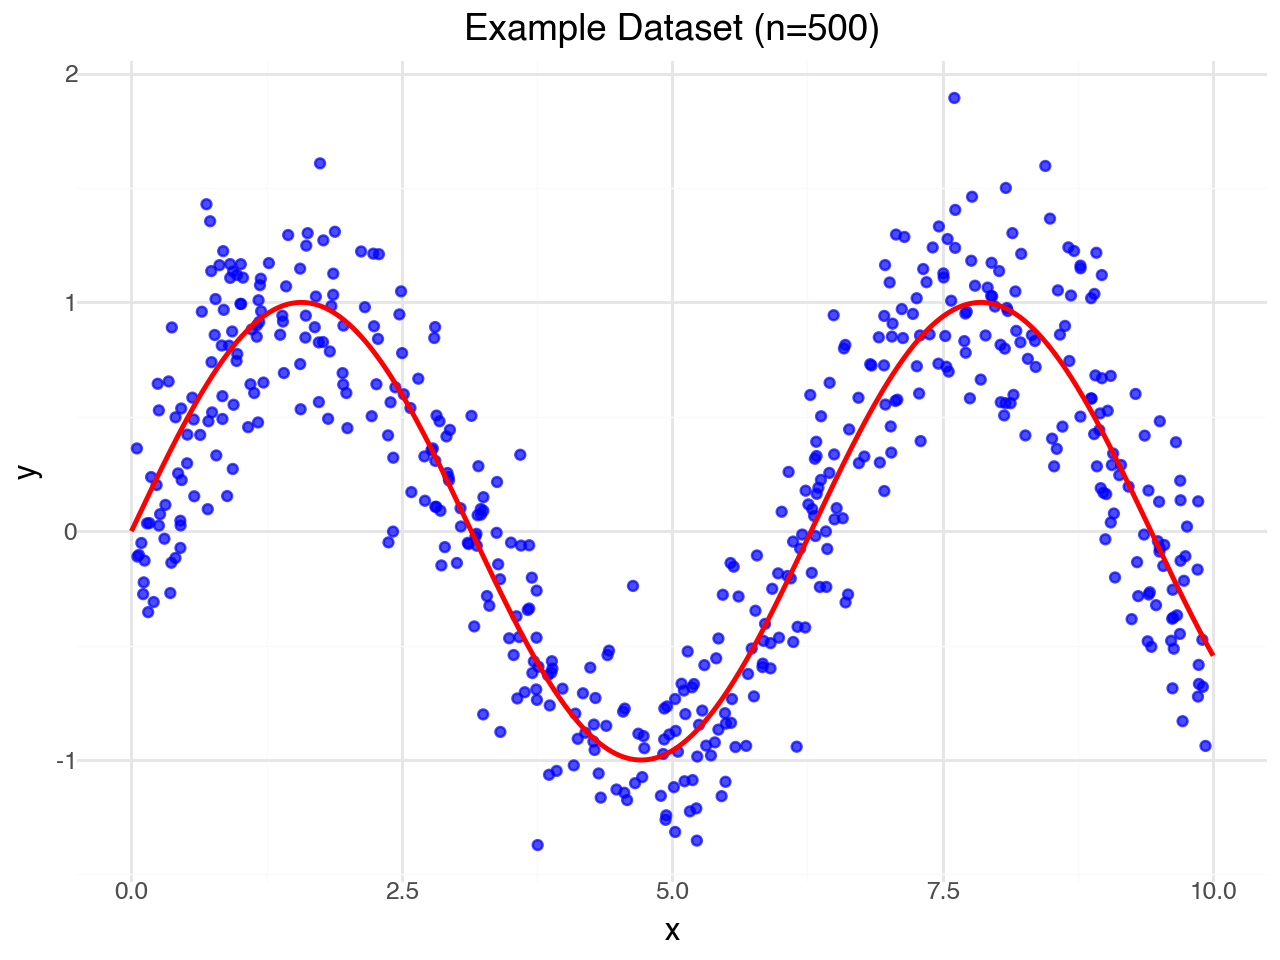

In [43]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_point, geom_line, labs, theme_minimal

n_test = 500

# Generate test data
np.random.seed(42)  # Optional: for reproducibility
x_test = np.random.uniform(x_min, x_max, n_test)
y_test = np.sin(x_test) + np.random.normal(0, sigma, n_test)

# Create a DataFrame for the test data
df_test = pd.DataFrame({'x' : x_test, 'y' : y_test})

# Create a DataFrame for the true function (line)
x_line = np.linspace(x_min, x_max, 1000)
df_line = pd.DataFrame({'x' : x_line, 'y' : np.sin(x_line)})


# Create the plot with plotnine
plot = (
    ggplot(df_test, aes(x='x', y='y')) +
    geom_point(color='blue', size=1.5, alpha=0.7) +
    geom_line(data=df_line, mapping=aes(x='x', y='y'), color='red', size=1) +
    labs(title='Example Dataset (n=500)', x='x', y='y') +
    theme_minimal()
)

plot

Locate the optimal node size hyperparameter for the regression tree model. The R exercise instructs to set `ntree = 1`, `replace = FALSE`, `sampsize = n` (`mtry` is already set to be 1 because there is only one feature) and then you can set `nodesize`. In sklearn we can just import DecisionTreeRegressor since it literally uses just one tree

   nodesize       mse
0         1  0.182561
1         2  0.140226
2         5  0.121491
3        10  0.104035
4        20  0.112223
5        50  0.126613
6       100  0.222088


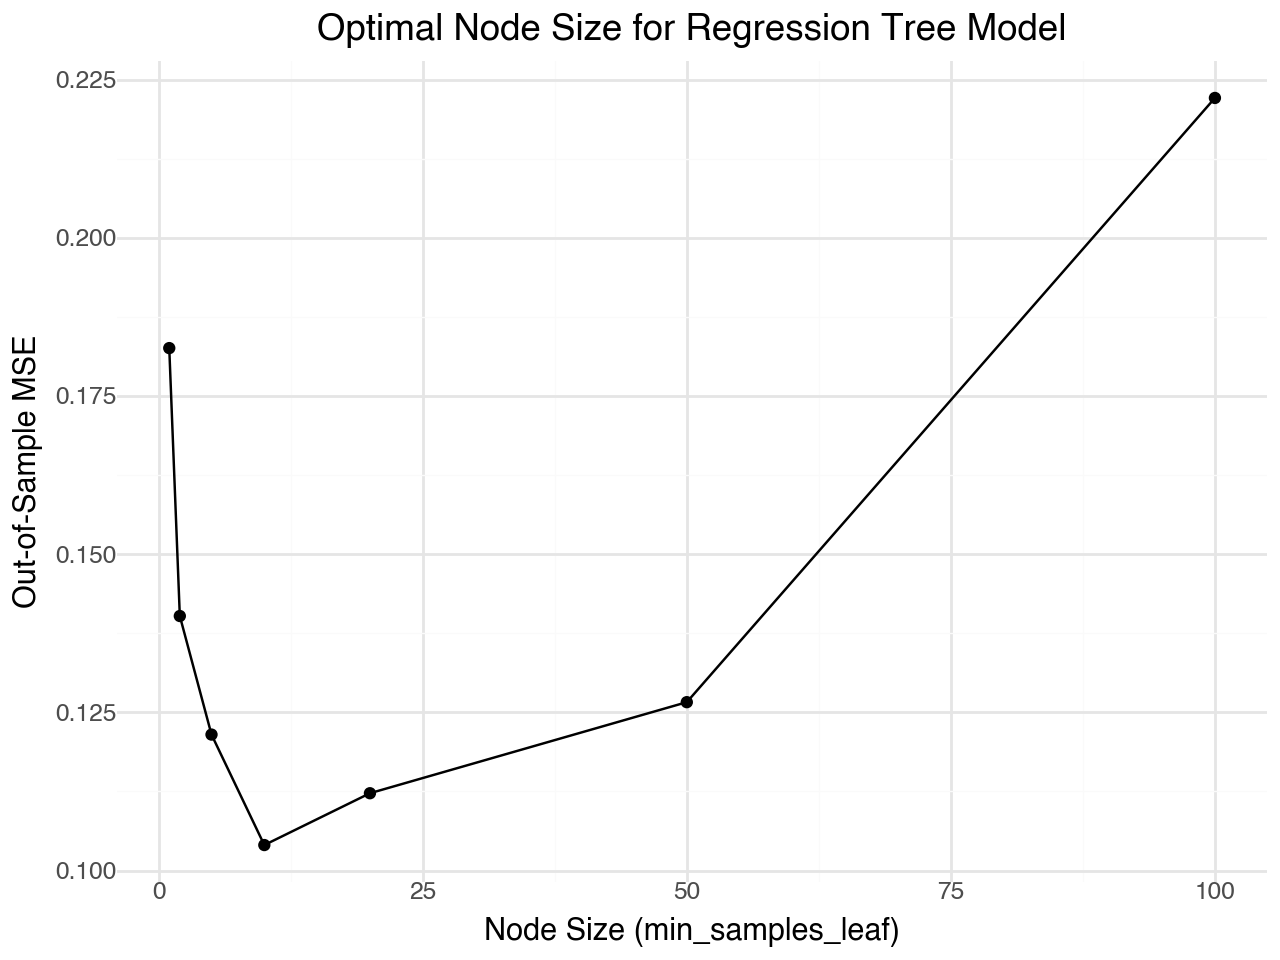

In [76]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_minimal

# ---------------------------
# Data Generation
# ---------------------------
n_train = 500
n_test = 500
sigma = 0.3
x_min = 0
x_max = 10

np.random.seed(42)

# Generate training data
x_train = np.random.uniform(x_min, x_max, n_train).reshape(-1, 1)
y_train = np.sin(x_train.flatten()) + np.random.normal(0, sigma, n_train)

# Generate test data
x_test = np.random.uniform(x_min, x_max, n_test).reshape(-1, 1)
y_test = np.sin(x_test.flatten()) + np.random.normal(0, sigma, n_test)

# ---------------------------
# Hyperparameter Tuning: Node Size
# ---------------------------
# "nodesize" in R corresponds to "min_samples_leaf" in sklearn.
node_sizes = [1, 2, 5, 10, 20, 50, 100]
errors = []

for nodesize in node_sizes:
    # Build a single regression tree
    model = DecisionTreeRegressor(min_samples_leaf=nodesize, random_state=42)
    model.fit(x_train, y_train)
    
    # Evaluate on the test set
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    errors.append(mse)

# Create a DataFrame with the results
df_results = pd.DataFrame({
    'nodesize': node_sizes,
    'mse': errors
})
print(df_results)
# ---------------------------
# Plotting with plotnine
# ---------------------------
plot = (
    ggplot(df_results, aes(x='nodesize', y='mse')) +
    geom_line() +
    geom_point() +
    labs(
        x="Node Size (min_samples_leaf)",
        y="Out-of-Sample MSE",
        title="Optimal Node Size for Regression Tree Model"
    ) +
    theme_minimal()
)

plot

In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

node_sizes = [1, 2, 5, 10, 20, 50, 100]
errors_rf = []

for nodesize in node_sizes:
    # Build a single-tree "forest" that mimics randomForest(ntree=1, replace=FALSE, sampsize=n)
    model = RandomForestRegressor(
       
    )
    model.fit(x_train, y_train)
    
    # Evaluate on the test set
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    errors_rf.append(mse)

# Side by side comparison between DecisionTreeRegressor and RandomForestRegressor:
import pandas as pd
df = pd.DataFrame({
    'nodesize': node_sizes,
    'DT MSE': errors,
    'RF(n=1) MSE': errors_rf
})
print(df)

   nodesize    DT MSE  RF(n=1) MSE
0         1  0.182561     0.135516
1         2  0.140226     0.135987
2         5  0.121491     0.133402
3        10  0.104035     0.135262
4        20  0.112223     0.135661
5        50  0.126613     0.134975
6       100  0.222088     0.133711


Plot the regression tree model g(x) with the optimal node size.

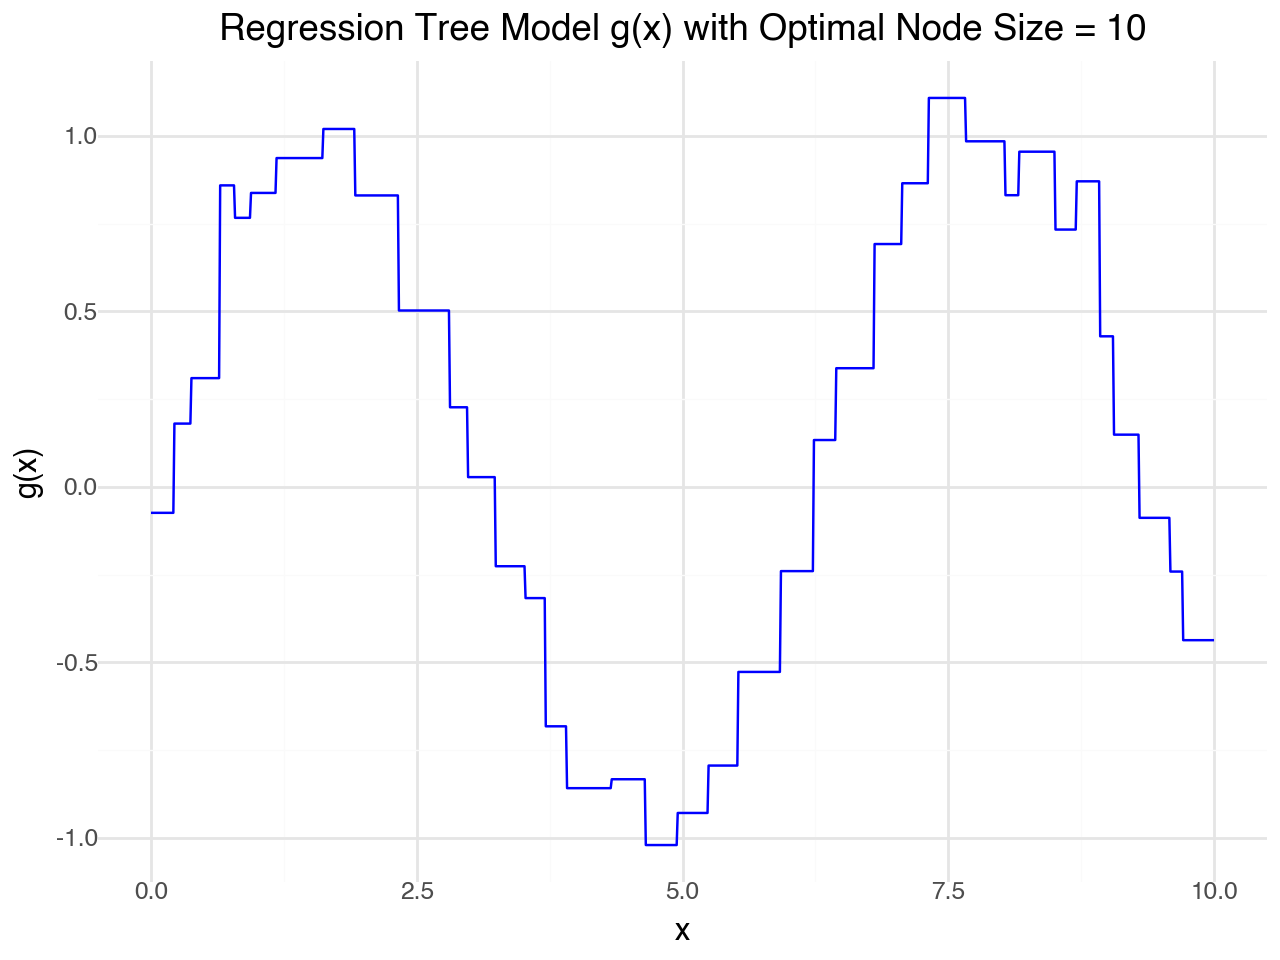

In [41]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from plotnine import ggplot, aes, geom_line, labs, theme_minimal

#Data Generation (Training Data)
n_train = 500
sigma = 0.3
x_min = 0
x_max = 10
np.random.seed(42)

#Generate training data
x_train = np.random.uniform(x_min, x_max, n_train).reshape(-1, 1)
y_train = np.sin(x_train.flatten()) + np.random.normal(0, sigma, n_train)


#Optimal Node Size (you can set this based on your results from the previous cell)
optimal_nodesize = 10

#Fit the Regression Tree Model with Optimal Node Size
model = DecisionTreeRegressor(min_samples_leaf = optimal_nodesize, random_state = 42)
model.fit(x_train, y_train)


#Generate Predictions for Plotting g(x) ... Create a fine grid of x values for a smooth curve
x_grid = np.linspace(x_min, x_max, 1000).reshape(-1, 1)
y_pred = model.predict(x_grid)

#Create a DataFrame with the predictions for plotting
df_plot = pd.DataFrame({
    'x': x_grid.flatten(),
    'g_x': y_pred
})

#Plot the Regression Tree Model using plotnine

plot = (
    ggplot(df_plot, aes(x='x', y='g_x')) +
    geom_line(color='blue') +
    labs(x="x", y="g(x)",
        title=f"Regression Tree Model g(x) with Optimal Node Size = {optimal_nodesize}") +
    theme_minimal()
    )

plot

Find the oosRMSE of this optimal-node-size model.

In [43]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


n_train = 500
n_test = 500
sigma = 0.3
x_min = 0
x_max = 10
np.random.seed(42)

#Generate training data
x_train = np.random.uniform(x_min, x_max, n_train).reshape(-1, 1)
y_train = np.sin(x_train.flatten()) + np.random.normal(0, sigma, n_train)

#Generate test data
x_test = np.random.uniform(x_min, x_max, n_test).reshape(-1, 1)
y_test = np.sin(x_test.flatten()) + np.random.normal(0, sigma, n_test)


#Train the Regression Tree Model
optimal_nodesize = 10
model = DecisionTreeRegressor(min_samples_leaf = optimal_nodesize, random_state = 42)
model.fit(x_train, y_train)

#Predict on the test set
y_pred = model.predict(x_test)


#Compute Out-of-Sample RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Out-of-Sample RMSE:", rmse)

Out-of-Sample RMSE: 0.32254514118053385


Provide the bias-variance decomposition of this DGP fit with this model. If your three numbers don't add up within two significant digits, increase your resolution.

Bias^2: 0.0002
Variance: 0.0156
Irreducible Error (sigma^2): 0.0900
Total (Bias^2 + Variance + sigma^2): 0.1059
Empirical MSE (averaged over grid): 0.0159


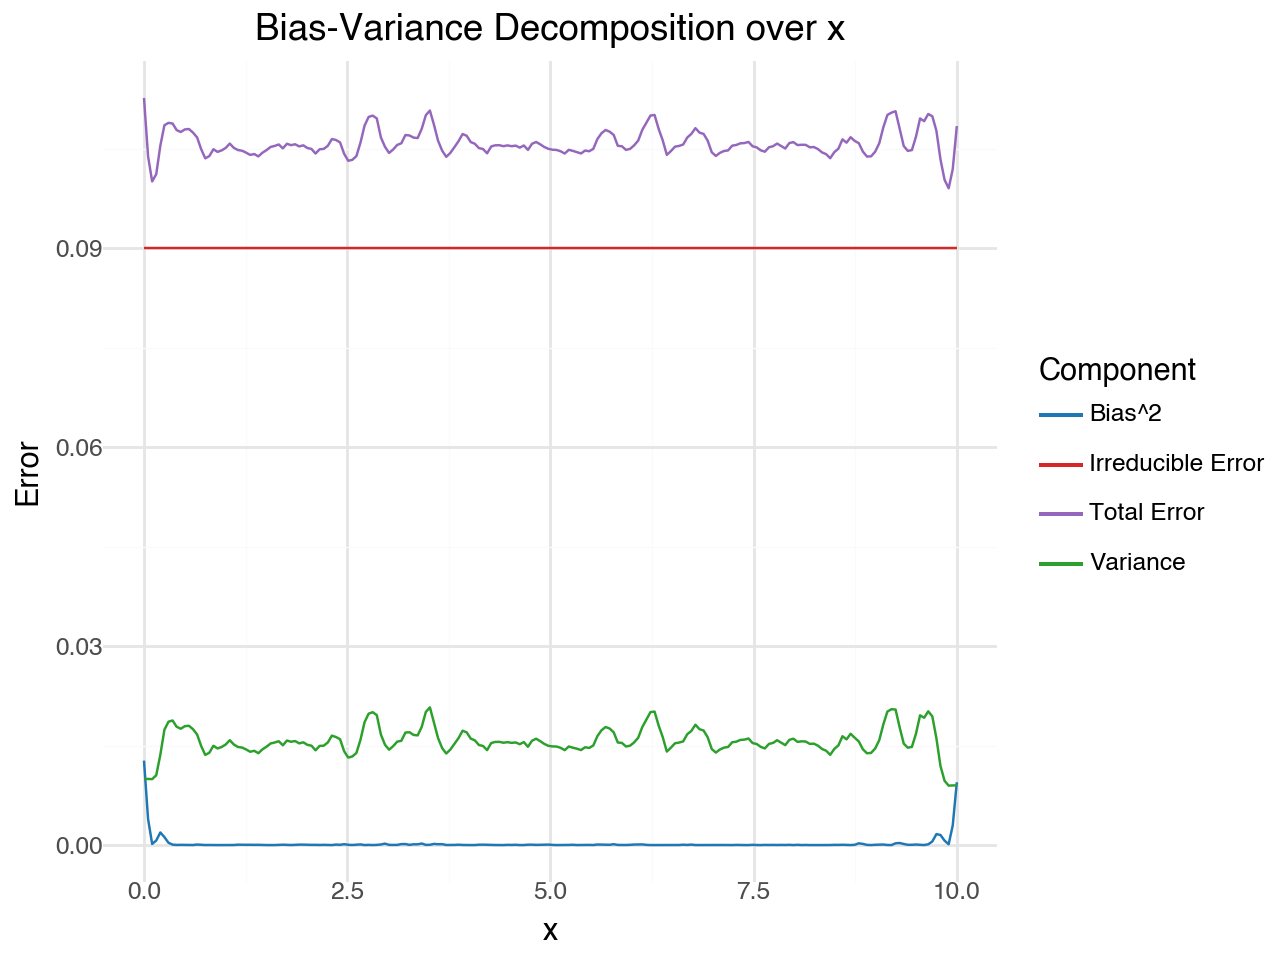

In [47]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, scale_color_manual
from sklearn.metrics import mean_squared_error


#Simulation Settings
n_train = 500         # Training sample size
sigma = 0.3           # Noise standard deviation
x_min = 0
x_max = 10
optimal_nodesize = 10  # Optimal node size (min_samples_leaf)

#Monte Carlo parameters
n_sim = 1000          # Number of simulation runs (increase for higher resolution)
n_grid = 200          # Number of grid points for evaluation

#Create a fine grid of x values for evaluation
x_grid = np.linspace(x_min, x_max, n_grid).reshape(-1, 1)
f_true = np.sin(x_grid.flatten())  # True function f(x) = sin(x)

#Array to store predictions for each simulation run (shape: n_sim x n_grid)
predictions = np.zeros((n_sim, n_grid))

#Set a seed for reproducibility
np.random.seed(42)


#Monte Carlo Simulation: Fit Model & Store Predictions
for i in range(n_sim):
    # Generate a training sample
    x_train = np.random.uniform(x_min, x_max, n_train).reshape(-1, 1)
    y_train = np.sin(x_train.flatten()) + np.random.normal(0, sigma, n_train)

    
    # Fit the regression tree model with the optimal node size
    model = DecisionTreeRegressor(min_samples_leaf = optimal_nodesize, random_state = 42)
    model.fit(x_train, y_train)

    # Predict on the evaluation grid
    predictions[i, :] = model.predict(x_grid)


#Bias-Variance Decomposition ... Average prediction at each grid point over all simulations
mean_predictions = np.mean(predictions, axis=0)

#Compute squared bias at each grid point: (f_true - mean_prediction)^2
bias_squared = (f_true - mean_predictions) ** 2

#Compute variance at each grid point: average squared deviation from the mean prediction
variance = np.mean((predictions - mean_predictions)**2, axis=0)

#Irreducible error (noise variance)
irreducible_error = sigma**2

#Total error(bias^2 + variance + irreducible error)
total_error = bias_squared + variance + irreducible_error


#Prepare Data for Plotting with plotnine
#Create a DataFrame with the computed components
df_plot = pd.DataFrame({
    'x': x_grid.flatten(),
    'Bias^2': bias_squared,
    'Variance': variance,
    'Irreducible Error': np.full(n_grid, irreducible_error),
    'Total Error': total_error
})

# Melt the DataFrame into long format for plotnine
df_long = pd.melt(df_plot, id_vars='x', var_name='Component', value_name='Error')

# Print Overall Averages
avg_bias_squared = np.mean(bias_squared)
avg_variance = np.mean(variance)
avg_total_error = np.mean(total_error)
print("Bias^2: {:.4f}".format(avg_bias_squared))
print("Variance: {:.4f}".format(avg_variance))
print("Irreducible Error (sigma^2): {:.4f}".format(irreducible_error))
print("Total (Bias^2 + Variance + sigma^2): {:.4f}".format(avg_bias_squared + avg_variance + irreducible_error))
print("Empirical MSE (averaged over grid): {:.4f}".format(np.mean((np.mean(predictions, axis=0) - f_true)**2 + variance)))


#Plot the Decomposition using plotnine
plot = (
    ggplot(df_long, aes(x='x', y='Error', color='Component')) +
    geom_line() +
    labs(title='Bias-Variance Decomposition over x', x='x', y='Error') +
    #manually set colors for clarity
    scale_color_manual(values={
        'Bias^2': '#1f77b4',
        'Variance': '#2ca02c',
        'Irreducible Error': '#d62728',
        'Total Error': '#9467bd'}) +
    theme_minimal()
)

plot

## Classification Trees

Let's get the letter recognition data from the by importing fetch_openml from the `sklearn.datasets` package.

In [50]:
from sklearn.datasets import fetch_openml

#Load the Letter Recognition dataset from OpenML ... the dataset is named 'letter' on OpenML
letter = fetch_openml('letter', version=1, as_frame=True)
df = letter.frame

#Print the number of rows (n = nrow(LetterRecognition) in R)
print("Number of rows:", df.shape[0])

#Display basic information (similar to skimr::skim)
print(df.info())
print(df.describe(include='all'))

Number of rows: 20000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   x-box   20000 non-null  int64   
 1   y-box   20000 non-null  int64   
 2   width   20000 non-null  int64   
 3   high    20000 non-null  int64   
 4   onpix   20000 non-null  int64   
 5   x-bar   20000 non-null  int64   
 6   y-bar   20000 non-null  int64   
 7   x2bar   20000 non-null  int64   
 8   y2bar   20000 non-null  int64   
 9   xybar   20000 non-null  int64   
 10  x2ybr   20000 non-null  int64   
 11  xy2br   20000 non-null  int64   
 12  x-ege   20000 non-null  int64   
 13  xegvy   20000 non-null  int64   
 14  y-ege   20000 non-null  int64   
 15  yegvx   20000 non-null  int64   
 16  class   20000 non-null  category
dtypes: category(1), int64(16)
memory usage: 2.5 MB
None
               x-box         y-box         width         high         onpix  \
count   200

This dataset has 20,000 examples. Create a training-select-test split so that they each have 1,000 observations.

In [52]:
from sklearn.model_selection import train_test_split


#First, randomly select 3,000 examples from the full dataset
subset, _ = train_test_split(df, train_size = 3000, random_state = 42, shuffle = True)

# Now, split the 3,000-example subset into training, select, and test sets (each 1,000 observations)
letters_train, temp = train_test_split(subset, train_size = 1000, random_state = 42, shuffle = True)
letters_select, letters_test = train_test_split(temp, train_size = 1000, random_state = 42, shuffle = True)


# Verify the sizes
print("Training set:", letters_train.shape[0])
print("Select set:", letters_select.shape[0])
print("Test set:", letters_test.shape[0])
letters_train

Training set: 1000
Select set: 1000
Test set: 1000


,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx,class
10177,5,11,7,8,9,6,5,3,2,6,5,6,5,8,15,3,S
5878,2,1,3,3,2,8,7,6,6,7,6,8,3,8,3,7,H
19504,3,8,4,5,2,7,8,15,1,7,5,8,3,8,0,8,H
18574,6,11,8,8,5,9,5,1,7,10,3,9,5,9,5,11,K
3959,2,0,2,1,0,3,13,5,2,11,8,5,0,8,2,7,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,5,10,6,7,4,6,7,7,7,9,8,11,2,8,5,9,G
5782,4,5,7,4,4,8,6,3,6,10,5,8,5,7,4,8,H
8533,5,8,5,6,4,1,10,3,3,11,11,9,5,11,1,7,W
488,3,5,4,4,2,6,7,5,5,9,7,10,2,9,4,10,G


Find the optimal classification tree by using the model selection algorithm to optimize the nodesize hyperparameter. Use misclassification error as the performance metric and plot the oos misclassification error by nodesize.

Nodesize (min_samples_leaf) = 1: Misclassification Error = 0.3430
Nodesize (min_samples_leaf) = 2: Misclassification Error = 0.3870
Nodesize (min_samples_leaf) = 5: Misclassification Error = 0.3790
Nodesize (min_samples_leaf) = 10: Misclassification Error = 0.4310
Nodesize (min_samples_leaf) = 20: Misclassification Error = 0.4720
Nodesize (min_samples_leaf) = 50: Misclassification Error = 0.6500
Nodesize (min_samples_leaf) = 100: Misclassification Error = 0.7920

Optimal nodesize (min_samples_leaf): 1
Misclassification Error at optimal nodesize: 0.343


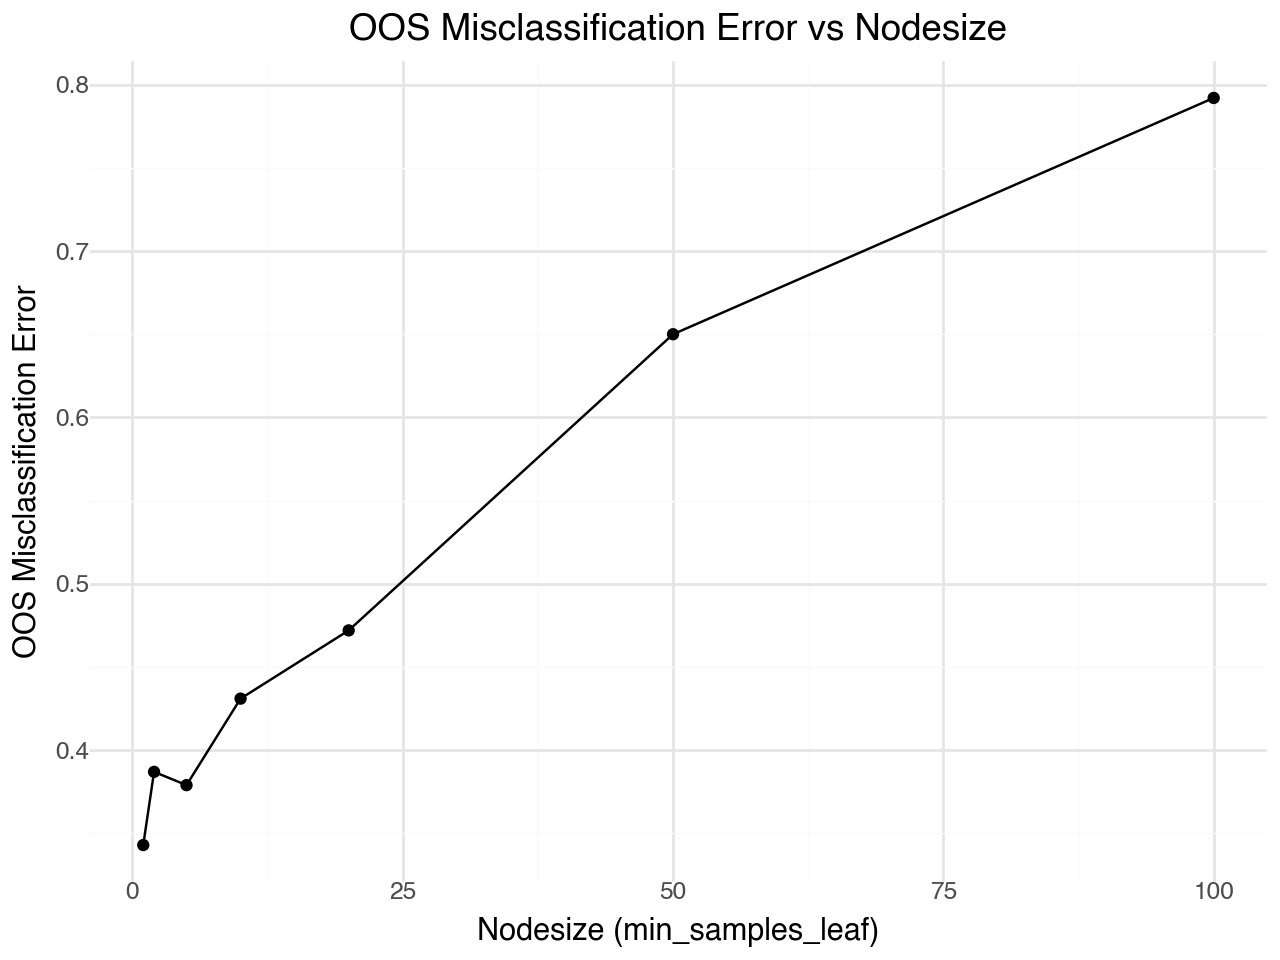

In [58]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_minimal

# Define candidate node sizes (min_samples_leaf values)
node_sizes = [1, 2, 5, 10, 20, 50, 100]

# List to store misclassification error on the select set for each candidate node size
misclassification_errors = []

# Loop over candidate node sizes
for ns in node_sizes:
    # Initialize the classifier with the current min_samples_leaf
    clf = DecisionTreeClassifier(min_samples_leaf = ns, random_state = 42)
    
    # Train the classifier using the training set (exclude the target column "class")
    clf.fit(letters_train.drop(columns = ['class']), letters_train['class'])
    
    # Predict on the select set
    y_pred = clf.predict(letters_select.drop(columns = ['class']))
    
    # Calculate misclassification error (proportion of incorrect predictions)
    error = np.mean(y_pred != letters_select['class'])
    misclassification_errors.append(error)
    
    print(f"Nodesize (min_samples_leaf) = {ns}: Misclassification Error = {error:.4f}")

#Create a DataFrame with the results for plotting
df_results = pd.DataFrame({
    'nodesize': node_sizes,
    'misclassification_error': misclassification_errors
})

#Identify the optimal node size (the one with the smallest misclassification error)
optimal_idx = np.argmin(misclassification_errors)
optimal_nodesize = node_sizes[optimal_idx]
optimal_error = misclassification_errors[optimal_idx]

print("\nOptimal nodesize (min_samples_leaf):", optimal_nodesize)
print("Misclassification Error at optimal nodesize:", optimal_error)


# Plot the OOS misclassification error by nodesize using plotnine
plot = (
    ggplot(df_results, aes(x='nodesize', y='misclassification_error')) +
    geom_line() +
    geom_point() +
    labs(
        title="OOS Misclassification Error vs Nodesize",
        x="Nodesize (min_samples_leaf)",
        y="OOS Misclassification Error"
    ) +
    theme_minimal()
)

plot

Construct the optimal classification tree on train and select sets. Then estimate generalization error. Save `y_hat_test` as we'll need it later.

In [68]:
from sklearn.tree import DecisionTreeClassifier

# Combine training and select sets to form the final training set.
letters_combined = pd.concat([letters_train, letters_select], axis = 0)

# Construct the optimal classification tree on the combined training set.
clf_opt = DecisionTreeClassifier(min_samples_leaf = optimal_nodesize, random_state = 42)
clf_opt.fit(letters_combined.drop(columns = ['class']),  letters_combined['class'])

#Estimate the generalization error on the test set.
y_hat_test = clf_opt.predict(letters_test.drop(columns=['class']))
test_error = np.mean(y_hat_test != letters_test['class'])

print("Generalization Error (Test Set Misclassification Error):", test_error)

Generalization Error (Test Set Misclassification Error): 0.264


Print out the top of the tree so we can have some level of interpretation to how the model g is predicting. Import export_text from sklearn.tree

In [71]:
from sklearn.tree import export_text

# Print the top of the tree (up to a maximum depth, e.g., 3 levels)
tree_text = export_text(clf_opt, feature_names = letters_combined.drop(columns = ['class']).columns.tolist(), max_depth = 10)
print(tree_text)

|--- y-bar <= 9.50
|   |--- x-ege <= 1.50
|   |   |--- y-ege <= 4.50
|   |   |   |--- xegvy <= 7.50
|   |   |   |   |--- xybar <= 9.50
|   |   |   |   |   |--- y2bar <= 4.00
|   |   |   |   |   |   |--- class: A
|   |   |   |   |   |--- y2bar >  4.00
|   |   |   |   |   |   |--- y-ege <= 3.50
|   |   |   |   |   |   |   |--- class: L
|   |   |   |   |   |   |--- y-ege >  3.50
|   |   |   |   |   |   |   |--- class: C
|   |   |   |   |--- xybar >  9.50
|   |   |   |   |   |--- x-bar <= 4.50
|   |   |   |   |   |   |--- class: C
|   |   |   |   |   |--- x-bar >  4.50
|   |   |   |   |   |   |--- class: J
|   |   |   |--- xegvy >  7.50
|   |   |   |   |--- xy2br <= 9.50
|   |   |   |   |   |--- x2ybr <= 5.50
|   |   |   |   |   |   |--- y-bar <= 2.50
|   |   |   |   |   |   |   |--- class: L
|   |   |   |   |   |   |--- y-bar >  2.50
|   |   |   |   |   |   |   |--- y-bar <= 7.50
|   |   |   |   |   |   |   |   |--- x2ybr <= 4.00
|   |   |   |   |   |   |   |   |   |--- class: J
|   |   |

Create a "confusion matrix". This means it shows every predicted level (which is a letter in our case) and every actual level. Here you'll see every type of error e.g. "P was predicted but the real letter is H", "M was predicted but the real letter is N" etc. We will use 'crosstab' from pandas for this. 

In [73]:
import pandas as pd

# Create the confusion matrix using pd.crosstab
conf_matrix = pd.crosstab(letters_test['class'], y_hat_test, rownames = ['actual'], colnames = ['predicted'])

# Print the confusion matrix
print(conf_matrix)


predicted   A   B   C   D   E   F   G   H   I   J  ...   Q   R   S   T   U  \
actual                                             ...                       
A          32   0   0   0   0   0   0   1   0   0  ...   0   0   0   0   0   
B           0  30   0   3   0   1   0   1   0   1  ...   0   3   1   0   0   
C           0   0  27   0   4   0   3   1   0   0  ...   0   3   0   0   0   
D           0   1   0  17   0   0   0   2   0   0  ...   0   5   1   0   0   
E           0   0   0   0  24   1   1   1   0   0  ...   0   0   0   0   0   
F           0   1   0   0   0  24   0   0   1   0  ...   0   0   0   0   1   
G           1   0   4   0   4   1  26   4   0   1  ...   0   0   4   0   1   
H           1   0   0   1   0   1   1  24   0   0  ...   0   1   1   0   0   
I           0   1   1   0   0   0   0   0  33   1  ...   0   0   1   0   0   
J           0   1   0   1   0   0   0   0   0  28  ...   0   0   1   0   0   
K           0   0   0   0   1   0   0   3   0   0  ...   2   4  

Which errors are most prominent in this model?

misclassification error